#**Importantando Bibliotecas**

In [1]:
# create predict analysis for the model when weight and year are the input features with multiple file xls and one xlsx

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.offline as py
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)
from sklearn.impute import SimpleImputer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Carregando arquivos**

In [3]:
# Load the data in folder data
path = "drive/MyDrive/Colab Notebooks/Dados Vigitel/Main/data"
files = os.listdir(path)
df = pd.DataFrame()
for file in files:
    if file.endswith(".xls") or file.endswith(".xlsx"):
        data = pd.read_excel(path + "/" + file)
        df = pd.concat([df, data])

#**Transformação**

In [4]:
df.rename(columns={"ano": "Ano","cidade": "Cidade" ,
                   "fet": "Faixa Etária", "q7": "Genero", "fesc": "Faixa de Escolaridade", "imc": "IMC",
                   "q42": "Exercicio Fisico", "q74": "Estado de Saúde", "q69" : "Cor"}, inplace=True)

In [5]:
pesquisa = df[["Ano", "Cidade", "IMC", "Faixa Etária", "Genero", "Faixa de Escolaridade", "Exercicio Fisico", "Estado de Saúde", "Cor"]]

In [6]:
pesquisa = pesquisa.dropna()
pesquisa = pesquisa.drop_duplicates()

In [7]:
pesquisa = pesquisa[pesquisa["Estado de Saúde"] != "777"]
pesquisa = pesquisa[pesquisa["Estado de Saúde"] != "888"]
pesquisa = pesquisa[pesquisa["Estado de Saúde"] != ""]
pesquisa = pesquisa[pesquisa["Cor"] != 777]
pesquisa = pesquisa[pesquisa["Cor"] != 888]
pesquisa = pesquisa[pesquisa["Cor"] != 666]
pesquisa = pesquisa[pesquisa["Cor"] != 555]
pesquisa = pesquisa[pesquisa["Cor"] != 80]


In [8]:
def faixaIMC(imc):
    if(imc < 18.5):
        return "Abaixo do peso"
    if(imc >= 18.5 and imc < 24.99):
        return "Peso normal"
    if(imc >= 25 and imc < 29.99):
        return "Sobrepeso"
    if(imc >= 30 and imc < 34.99):
        return "Obesidade grau 1"
    if(imc >= 35 and imc < 39.99):
        return "Obesidade grau 2"
    if(imc >= 40):
        return "Obesidade grau 3"
pesquisa["Faixa IMC"] = pesquisa["IMC"].apply(faixaIMC)

In [9]:
#Float to Integer
pesquisa["Faixa de Escolaridade"] = pesquisa["Faixa de Escolaridade"].astype(int)
pesquisa["Estado de Saúde"] = pesquisa["Estado de Saúde"].astype(int)


# **SVD**

In [10]:
#Dropando se há nulo ou duplicados
pesquisa = pesquisa.dropna()
pesquisa = pesquisa.drop_duplicates()

In [11]:
df_ = pesquisa.drop(['Ano', "Faixa IMC"], axis= 1)
df_ = StandardScaler().fit_transform(df_)
pca = PCA()
pca_fit = pca.fit_transform(df_)
pca.explained_variance_ratio_

array([0.18124227, 0.13919026, 0.13499929, 0.12503736, 0.12365842,
       0.10955154, 0.10661675, 0.07970411])

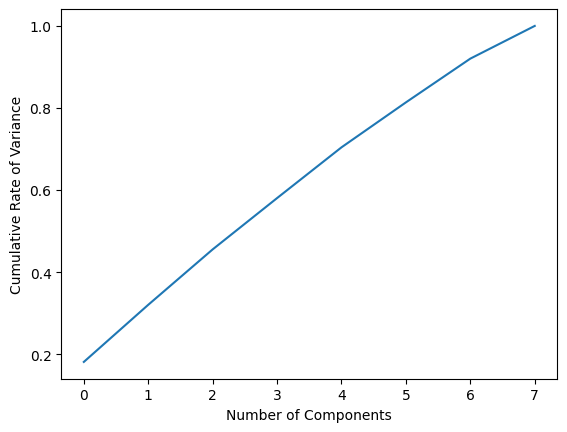

In [12]:
pca = PCA().fit(df_)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Rate of Variance")
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.show()

In [13]:
var1 = np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 4) * 100)
print(var1)

[ 18.12  32.04  45.54  58.04  70.41  81.37  92.03 100.  ]


Text(0, 0.5, 'Cumulative Proportion variance explained')

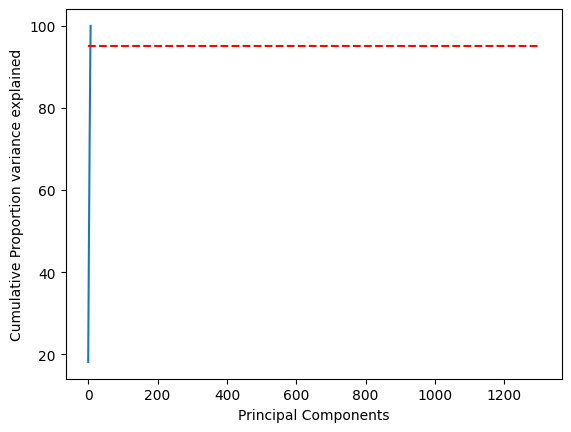

In [14]:
plt.plot(var1)
plt.hlines(95,0,1300,colors='red',linestyles='dashed')
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Proportion variance explained")

In [15]:
# Encontrar o componente principal que é maior que 95 %
Num_components = var1<95
print("Optimum Number of Components", Num_components.sum())

Optimum Number of Components 7


# **Iniciando PCA**

In [16]:
pesquisa = pesquisa.dropna()
pesquisa = pesquisa.drop_duplicates()

In [17]:
pesquisaPCA = pesquisa.copy()
pesquisaPCA = pesquisaPCA.reset_index(drop=True)
pesquisaPCA = pesquisaPCA.replace(to_replace='None', value=np.nan).dropna()
pesquisaPCA = pesquisaPCA.dropna()
pesquisaPCA = pesquisaPCA.drop_duplicates()

In [18]:
y = pesquisaPCA['Faixa IMC'] # Variável Dependente
X = pesquisaPCA.drop(['Ano', 'Faixa IMC', "IMC"], axis=1) # Variável Independente

def create_pca_df(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=pca_fit, columns=['PC1', 'PC2'])
    final_df = pd.concat([pca_df, pd.DataFrame(y)], axis=1, ignore_index=True)
    return final_df

pca_df = create_pca_df(X, y)
#Renomeando Colunas
pca_df.columns = ['PC1', 'PC2', 'Faixa IMC']
pca_df.head()

,PC1,PC2,Faixa IMC
0,-1.537298,0.110167,Peso normal
1,-1.538160,1.264436,Sobrepeso
2,-0.422386,0.314159,Sobrepeso
3,0.877403,0.361323,Sobrepeso
4,0.204644,0.595240,Obesidade grau 1


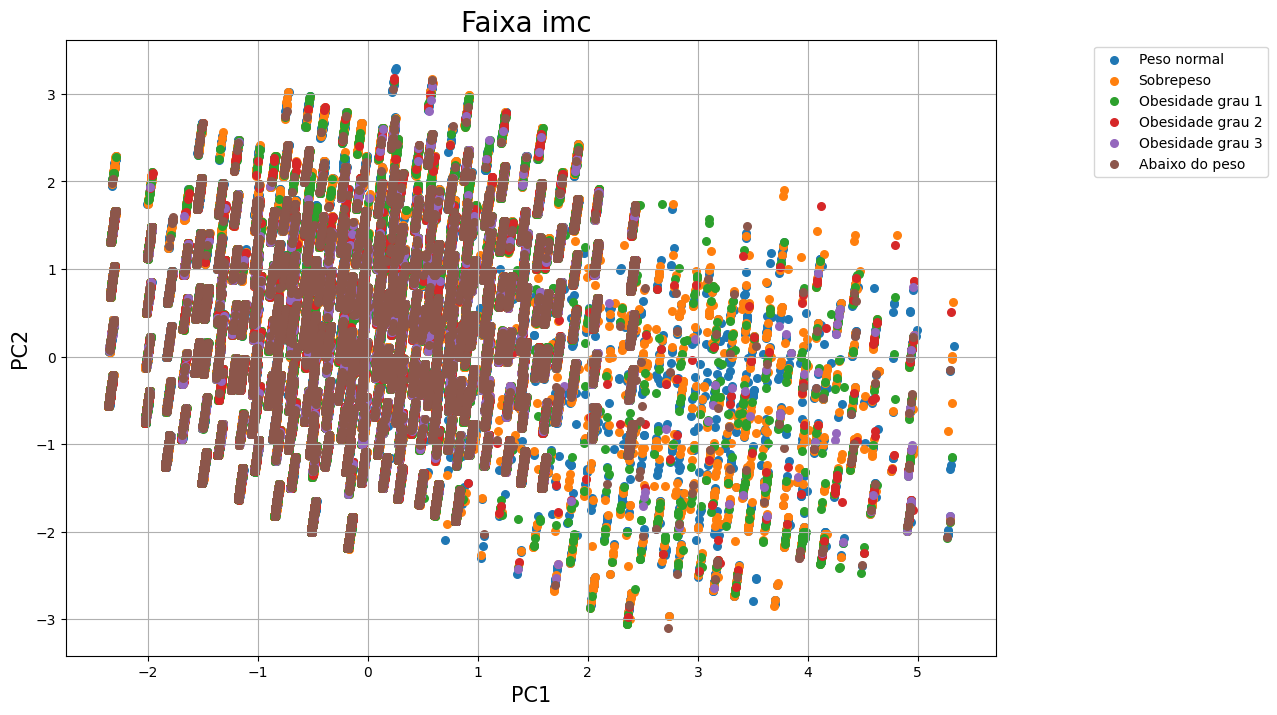

In [24]:
def plot_pca(dataframe, target):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PC1', fontsize=15)
    ax.set_ylabel('PC2', fontsize=15)
    ax.set_title(f'{target.capitalize()} ', fontsize=20)

    targets = list(dataframe[target].unique())
    a = len(targets)

    for t in targets:
        indices = dataframe[target] == t
        ax.scatter(dataframe.loc[indices, 'PC1'], dataframe.loc[indices, 'PC2'], s=30)
    ax.legend(targets, loc='upper right', bbox_to_anchor=(1.3, 1))
    ax.grid()
    plt.show()

plot_pca(pca_df, "Faixa IMC")

In [25]:
# Calcular e imprimir a matriz de covariância
cov_matrix = np.cov(X.T)
print("Matriz de Covariância:")
print(cov_matrix)

#Dois maiores autovalores:

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print("\nAutovalores:")
print(eigenvalues)
print("\nAutovetores:")
print(eigenvectors)

# Ordenar os autovalores e autovetores em ordem decrescente
eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(len(eigenvalues))]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

# Selecionar os dois maiores autovalores e autovetores
top_eigenvalues = eigen_pairs[0][0], eigen_pairs[1][0]
top_eigenvectors = eigen_pairs[0][1], eigen_pairs[1][1]

print("\nDois maiores autovalores:")
print(top_eigenvalues)
print("\nDois maiores autovetores:")
print(top_eigenvectors)

Matriz de Covariância:
[[ 6.09449119e+01  5.17707763e-02  1.04224283e-02  1.17984759e-01
   3.03346245e-02  9.30222910e-01 -2.54456578e-02]
 [ 5.17707763e-02  2.68912937e+00  6.24210523e-02 -3.13975557e-01
   5.60762684e-02  4.63354599e+00 -2.04709304e-01]
 [ 1.04224283e-02  6.24210523e-02  2.40292095e-01  6.94587400e-04
   2.87718958e-02  5.99708825e-02 -1.70514689e-02]
 [ 1.17984759e-01 -3.13975557e-01  6.94587400e-04  6.02290109e-01
  -7.50077950e-02 -1.86285081e+00 -8.56124650e-02]
 [ 3.03346245e-02  5.60762684e-02  2.87718958e-02 -7.50077950e-02
   2.48649097e-01  6.71010338e-01  1.56912882e-02]
 [ 9.30222910e-01  4.63354599e+00  5.99708825e-02 -1.86285081e+00
   6.71010338e-01  2.88898364e+03 -4.14593678e-01]
 [-2.54456578e-02 -2.04709304e-01 -1.70514689e-02 -8.56124650e-02
   1.56912882e-02 -4.14593678e-01  1.71046405e+00]]

Autovalores:
[2.88899281e+03 6.09449090e+01 2.76460917e+00 1.68825690e+00
 5.56914289e-01 2.64567291e-01 2.07316558e-01]

Autovetores:
[[-3.28933381e-04 -9.